In [3]:
import glob
from io import open
import pandas as pd
from pandas import DataFrame as df
from os import path
import re
import gensim
import numpy as np
from collections import Counter

In [4]:
import nltk

//anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [5]:
from nltk import word_tokenize

In [6]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [7]:
from tools import get_psycinfo_database

In [8]:
words_df = get_psycinfo_database()

In [9]:
words_df.head()

,Abstract,Accession Number,Author(s),Type of Book,PsycINFO Classification Code,Conference,Document Type,Grant/Sponsorship,Key Concepts,Institution,...,Population Group,Publication Status,Publication Type,Publisher,Cited References,Title,Tests & Measures,Volume,Date,Term
0,PURPOSE: Rates of alcohol use may be increasin...,Peer Reviewed Journal: 2015-52719-001.,"Kane, Jeremy C\n\nJohnson, Renee M\n\nRobinson...",NaN,Health & Mental Health Treatment & Prevention ...,NaN,NaN,NaN,"Acculturation, Intergenerational cultural diss...",NaN,...,NaN,First Posting,Journal\n\nPeer Reviewed Journal,Elsevier Science; Netherlands,NaN,The impact of intergenerational cultural disso...,NaN,NaN,2015,bicultural
1,Given the negative developmental risks associa...,Peer Reviewed Journal: 2015-52548-001.,"Killoren, Sarah E\n\nZeiders, Katharine H\n\nU...",NaN,Developmental Psychology [2800].,NaN,NaN,NaN,"Adolescence, Cultural context, Mexican-America...","Killoren, Sarah E.: Department of Human Develo...",...,NaN,First Posting,Journal\n\nPeer Reviewed Journal,Springer; Germany,NaN,The sociocultural context of mexican-origin pr...,NaN,NaN,2015,bicultural
2,(from the chapter) Assessment science is an es...,Book: 2013-02670-011.,"Dana, Richard H",Handbook/Manual,Personality Scales & Inventories [2223].,NaN,Chapter,NaN,"personality tests, psychology, assessment, cul...",NaN,...,Human,NaN,Book\n\nEdited Book,American Psychological Association; US,"Aiken, L. S., West, S. G., & Millsap, R. E. (2...",Personality tests and psychological science: I...,California Brief Multicultural Competency Scal...,NaN,2014,bicultural
3,Objective: The aim of the study was to explore...,Peer Reviewed Journal: 2015-46649-006.,"Goutaudier, N\n\nChauchard, E\n\nMelioli, T\n\...",NaN,Psychosocial & Personality Development [2840].,NaN,Journal Article,NaN,"Acculturation, Adolescence, Cluster analysis, ...","Goutaudier, N.: Laboratoire CERPP-OCTOGONE, UF...",...,Human. Male. Female. Adolescence (13-17 yrs),NaN,Journal\n\nPeer Reviewed Journal,Elsevier Masson SAS; France,"Aubry, B., & Tribalat, M. (2009). Les jeunes d...",Acculturation orientations and psychosocial ad...,Immigrant Acculturation Scale\nRosenberg Self-...,41,2015,bicultural
4,"(from the chapter) In Germany, the visit of th...",Book: 2014-27297-015.,"Leyendecker, Birgit\n\nWillard, Jessica\n\nAga...",NaN,Cognitive & Perceptual Development [2820].,NaN,Chapter,<b>Sponsor: </b>NORFACE. ERA-NET\n<b>Grant: </...,"children's bilingual development, parents, imm...","Leyendecker, Birgit: Ruhr University Bochum, B...",...,Human. Childhood (birth-12 yrs),NaN,Book\n\nEdited Book,Ashgate Publishing Co; US,"Adesope, O. O., Lavin, T., Thompson, T., & Ung...",Learning a host country: A plea to strengthen ...,NaN,NaN,2014,bicultural


## Generate Corpora

In [10]:
words_to_replace = {"/":"-", "bi-ethnic": "biethnic", "bi-racial": "biracial", 
                    "mono-ethnic": "monoethnic", "poly-ethnic": "polyethnic", 
                    "mono-racial": "monoracial", "multi-racial": "multiracial",
                    "inter-racial": "interracial", "mono-cultural": "monocultural",
                    "bi-cultural": "bicultural", "multi-cultural": "multicultural",
                    "other ethnicity":"other-ethnicity", "other race": "other-race", 
                    "mixed race": "mixed-race", "mixed ethnicity": "mixed-ethnicity"}

In [11]:
abstract_text = [[x_.lower() for x_ in word_tokenize(x)] for x in words_df.Abstract.fillna("").values]

In [12]:
abstract_text[0][:10]

['purpose',
 ':',
 'rates',
 'of',
 'alcohol',
 'use',
 'may',
 'be',
 'increasing',
 'among']

In [13]:
print("Number of Abstracts", len(abstract_text))
print("Number of words", sum(len(x) for x in abstract_text))

Number of Abstracts 28305
Number of words 5986261


In [14]:
model = gensim.models.Word2Vec(sentences=abstract_text, size=32, window=5, min_count=2, sample=0,
                               workers=10, hs=1, sg=1, cbow_mean=0)

In [15]:
model.most_similar_cosmul("multicultural")

[('counseling', 0.9555028676986694),
 ('counselling', 0.9420709609985352),
 ('mc', 0.9381777048110962),
 ('competency', 0.9301022887229919),
 ('globalization-cultural', 0.9291765093803406),
 ('cross-cultural', 0.9274942278862),
 ('competence', 0.9241160750389099),
 ('counsellor', 0.9228037595748901),
 ('transcultural', 0.9199246168136597),
 ('vocational', 0.9197516441345215)]

In [16]:
model.most_similar_cosmul("biracial")

[('multiracial', 0.9304053783416748),
 ('asian-white', 0.9253990054130554),
 ('black/white', 0.9180924892425537),
 ('adoptees', 0.917337954044342),
 ('mixed-heritage', 0.9168943762779236),
 ('mixed-race', 0.9097462296485901),
 ('inauthenticity', 0.9095105528831482),
 ('individuals', 0.9047248959541321),
 ('monoracial', 0.9044837355613708),
 ('biethnic', 0.9022374749183655)]

In [17]:
model.most_similar_cosmul("monoracial")

[('asian-white', 0.9484656453132629),
 ('ancestry', 0.9340470433235168),
 ('part-latino', 0.9262325167655945),
 ('single-race', 0.9246559143066406),
 ('nonwhite', 0.9243330359458923),
 ('inauthenticity', 0.9223437905311584),
 ('5,824', 0.9218804240226746),
 ('mixed-raced', 0.9185484051704407),
 ('aims-defined', 0.9182586073875427),
 ('minority-white', 0.9155025482177734)]

In [18]:
model.most_similar_cosmul("bicultural", topn=10)

[('biculturalism', 0.9172696471214294),
 ('self-identity', 0.9154881834983826),
 ('acculturation', 0.9152664542198181),
 ('biculturality', 0.9126729369163513),
 ('bi-cultural', 0.9056810140609741),
 ('monocultural', 0.9005785584449768),
 ('bii', 0.898722767829895),
 ('identity', 0.8964405059814453),
 ('fusion', 0.8939148187637329),
 ('enculturation', 0.893640398979187)]

## Hierchical Clustering

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [20]:
words = ['monocultural', 'monoracial', 'bicultural', 'biracial', 'biethnic', 'interracial',
        'multicultural', 'multiracial', 'multiethnic', 'polycultural', 'polyracial', 'polyethnic',
        'mixed race', 'mixed ethnicity', 'other race', 'other ethnicity', 'multiculturalism', 'polyculturalism',
         'cultural pluralism']

In [21]:
expansion = []
for w in words:
    if w in model:
        expansion.extend([x for x,y in model.most_similar(w, topn=50)])
counter = Counter(expansion)
expansion = [x for x, y in counter.items() if y > 2]

In [22]:
y = []
X = []
for w in set(words + expansion):
    if w in model:
        X.append(model[w])
        y.append(w)
X = np.asarray(X)
X = (X.T / np.linalg.norm(X, axis=1)).T

In [23]:
X.shape

(24, 32)

In [24]:
Z = linkage(X, 'ward')

//anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


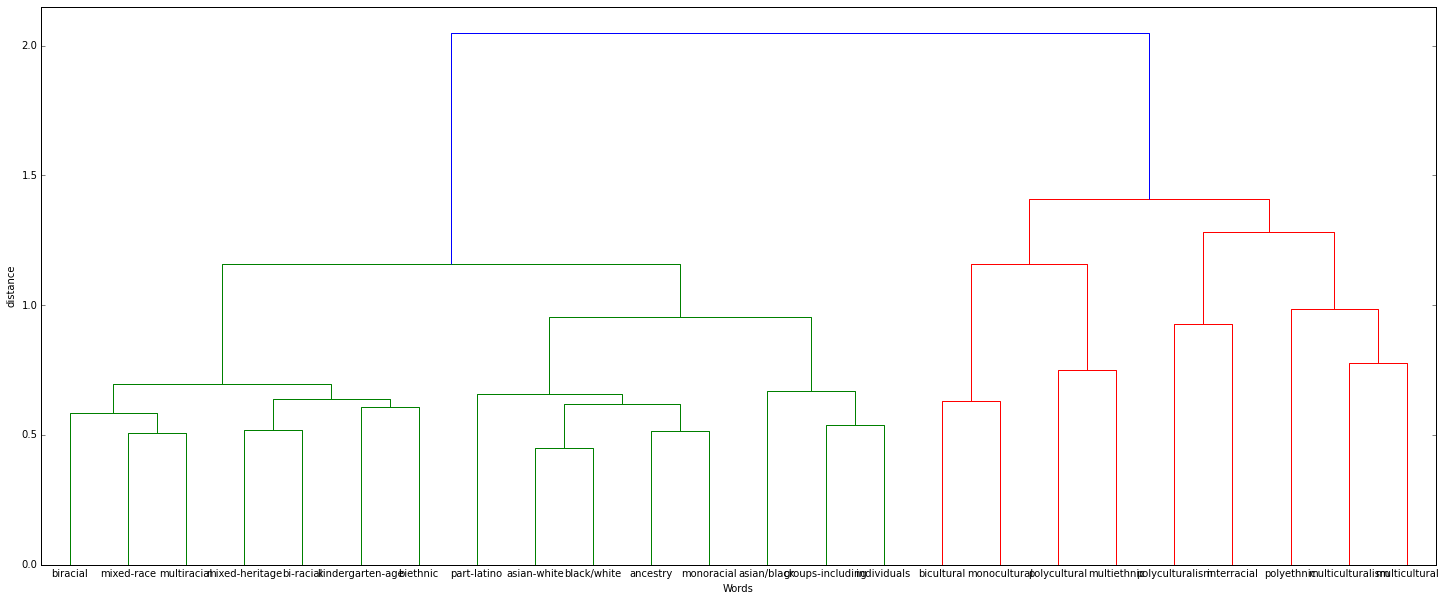

In [44]:
plt.figure(figsize=(25, 10))
#plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('distance')
_ = dendrogram(Z, labels=y, leaf_rotation=90., leaf_font_size=16.)

## TODOs

1. Foo
1. Bar
